### Wakefield simulation of the LHC unshielded bellows with `wakis`
* Creation of the geometry from simple geometry blocks (CSG) -> fully parametrized 

In [1]:
import sys
sys.path.append('../wakis')

In [ ]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl
pv.set_jupyter_backend('client')

### Construction of the geometry

In [3]:
# beam pipe
r_pipe = 24e-3      # pipe radius [m]
l_pipe = 320e-3     # pipe length [m]
pipe = pv.Cylinder(center=(0,0,0), direction=(0,0,1), radius=r_pipe, height=l_pipe)

# convolutions
r_conv = 30e-3  # convolution radius [m]
l_conv = 4e-3  # length of each convolution [m]
n_conv = 15      # number of convolutions
l_between_conv = 4e-3  # length between convolutions [m]
z_start = n_conv//2*(l_conv + l_between_conv) - l_conv # start of the convolutions [m]
convolutions = []

for n in range(n_conv):
    z_start_n_conv = -z_start+n*(l_conv+l_between_conv)
    conv = pv.Cylinder(center=(0,0,z_start_n_conv),     # center of the convolution
                       direction=(0,0,1),  # z-direction
                       radius=r_conv, 
                       height=l_conv)
    convolutions.append(conv)  # append to list

# Sum the generated geometry
pipe = pipe.triangulate()                          # triangulate pipe
convolutions = np.sum(convolutions).triangulate()  # triangulate convolutions
bellow = pipe | convolutions  # union of meshes without internal faces

# Plot the generated geometry
bellow.clear_data()         # remove tringulation distance data   
bellow.plot(scalars=None, opacity=0.7)

# Save it to file
stl_file = '011_LHC_Bellows/011_LHC_Bellow_generated.stl'
# bellow.scale(1e3).save(stl_file) #save in [mm]
bellow.save(stl_file) #save in [m]

Widget(value='<iframe src="http://localhost:33935/index.html?ui=P_0x7f3266f73dd0_0&reconnect=auto" class="pyvi…

In [4]:
# Comparison with STL base file
base_stl_file = '011_LHC_Bellows/011_PIMS_Bellow_for_CAS.stl'
base_surf = pv.read(base_stl_file).scale(1e-3)                 # scale from [mm] to [m]
base_surf = base_surf.translate(-1*np.array(base_surf.center)) # center in [0,0,0]
#base_surf.plot()
#base_surf.bounds

if True:
    pl = pv.Plotter()
    pl.add_mesh(base_surf, color='blue', style='wireframe', opacity=0.5, label='base STL')
    pl.add_mesh(bellow, color='green', opacity=0.8, label='generated STL')
    pl.show()

Widget(value='<iframe src="http://localhost:33935/index.html?ui=P_0x7f3246d8bcd0_1&reconnect=auto" class="pyvi…

### Domain setup and grid generation

In [5]:
# ---------- Domain setup ---------
# Set up geometry & materials dictionaries
stl_solids = {'bellow': stl_file}
stl_materials = {'bellow': 'vacuum'}

# Domain bounds
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Number of mesh cells
Nx = 60
Ny = 60
Nz = 220
print(f'Total number of mesh cells: {Nx*Ny*Nz}')

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,)

Total number of mesh cells: 792000
Generating grid...
Importing stl solids...


In [6]:
#pv.set_jupyter_backend('trame')
#grid.inspect()
#grid.plot_solids()

### Boundary conditions and EM solver

In [7]:
# boundary conditions
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

n_pml = 10 # number of PML layers
solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, 
                     bg='pec',
                     n_pml=n_pml)

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Filling PML sigmas...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.5545732975006104 s


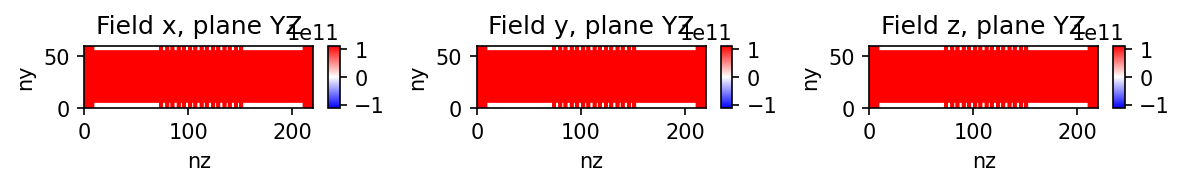

In [ ]:
solver.ieps.inspect(dpi=200, )

### Wakefield settings & Run

The wakefield simulation will run up to 10 m which will give a partially decayed wake and a non-converged impedance - this will be the starting point of IDDEFIX extrapolation !

In [9]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-3      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 5e-3           # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = n_pml + 2  # no. cells to skip from wake integration (>= PML cells)
results_folder = '011_LHC_Bellows/011_results/'

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                skip_cells=skip_cells,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength 

In [10]:
# Plot settings
import os
if not os.path.exists(results_folder+'img/'): os.mkdir(results_folder+'img/')
plotkw = {'title':results_folder+'img/Ez', 
            'add_patch':'bellow', 'patch_alpha':0.3,
            'vmin':-1e4, 'vmax':1e4,
            'plane': [int(Nx/2), slice(0, Ny), slice(0, Nz)],}

solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 plot=False,
                 plot_every=50, 
                 plot_until=5000,
                 **plotkw)

Running electromagnetic time-domain simulation...


100%|██████████| 32720/32720 [31:02<00:00, 17.56it/s]  


Reading h5 file 011_LHC_Bellows/011_results/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|██████████| 285471/285471 [01:07<00:00, 4232.23it/s]


Calculating transverse wake potential WPx, WPy...


100%|██████████| 285471/285471 [00:02<00:00, 125398.05it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


It's done! Now we can plot the results:

In [11]:
# plot the Ez field gif
#! convert -delay 5 -loop 0 011_LHC_Bellows/011_results/img/Ez_*.png 011_LHC_Bellows/011_results/img/Ez.gif

In [25]:
# Recalculate the wake field with a different number of cells to skip
wake.skip_cells = n_pml + 20
wake.solve()

Calculating longitudinal wake potential WP(s)


100%|██████████| 285471/285471 [00:59<00:00, 4831.32it/s]


Calculating transverse wake potential WPx, WPy...


100%|██████████| 285471/285471 [00:02<00:00, 140091.65it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


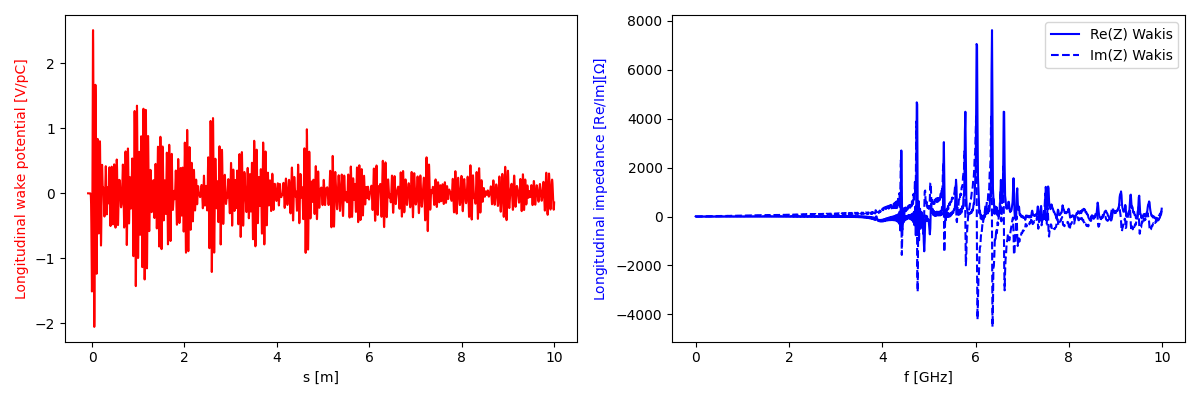

In [26]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WP, c='r', lw=1.5, label='WP Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Re(Z) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', ls='--', lw=1.5, label='Im(Z) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Re/Im][$\Omega$]', color='b')

fig.tight_layout()

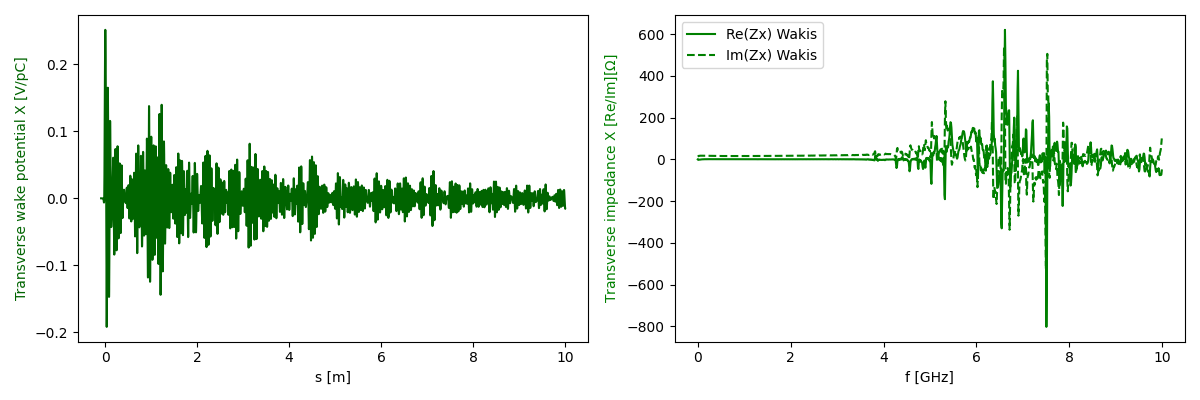

In [27]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WPx, c='darkgreen', lw=1.5, label='WPx Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='darkgreen')

ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='g', lw=1.5, label='Re(Zx) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='g', ls='--', lw=1.5, label='Im(Zx) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Re/Im][$\Omega$]', color='g')

fig.tight_layout()

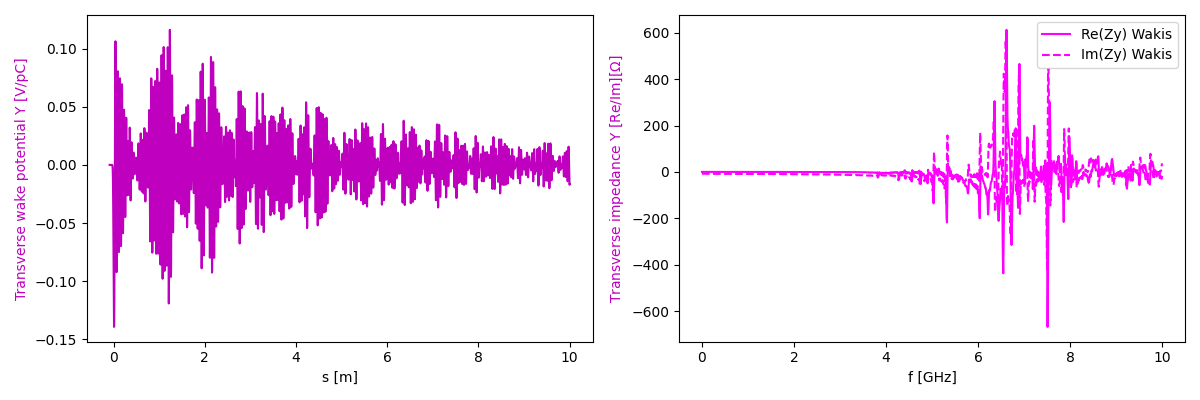

In [28]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WPy, c='m', lw=1.5, label='WPy Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='m')

ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='magenta', lw=1.5, label='Re(Zy) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='magenta', ls='--', lw=1.5, label='Im(Zy) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance Y [Re/Im][$\Omega$]', color='m')

fig.tight_layout()

### Compare with CST

In [16]:
WP_cst = wake.read_txt('011_LHC_Bellows/dipolar_x_wake.txt')
Zx_cst = wake.read_txt('011_LHC_Bellows/dipolar_x_impedance.txt')

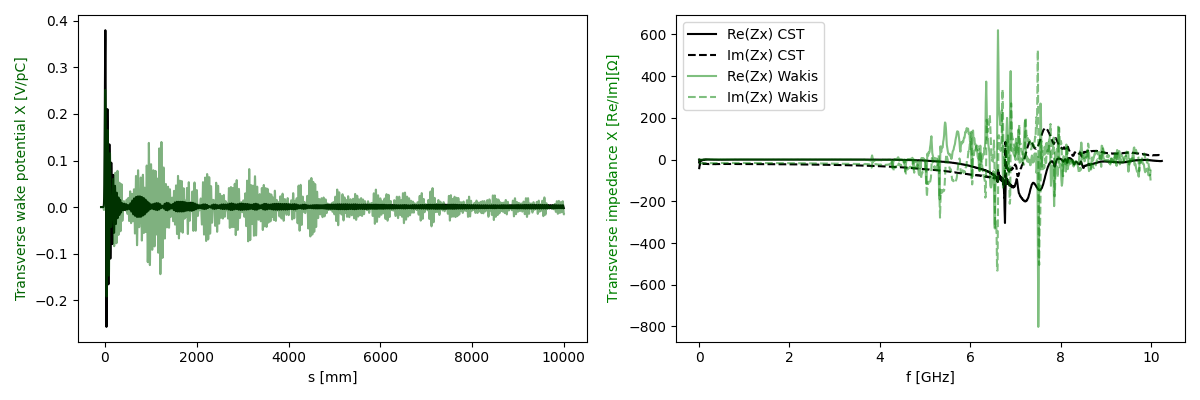

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)

ax[0].plot(WP_cst[0], WP_cst[1], c='k', lw=1.5, label='WPx CST')

ax[0].plot(wake.s*1e3, wake.WPx, c='darkgreen', lw=1.5, alpha=0.5, label='WPx Wakis')
ax[0].set_xlabel('s [mm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='darkgreen')

ax[1].plot(Zx_cst[0], Zx_cst[1], c='k', lw=1.5, label='Re(Zx) CST')
ax[1].plot(Zx_cst[0], Zx_cst[2], c='k', ls='--', lw=1.5, label='Im(Zx) CST')

ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='g', alpha=0.5, lw=1.5, label='Re(Zx) Wakis')
ax[1].plot(wake.f*1e-9, -1*np.imag(wake.Zx), c='g', ls='--', alpha=0.5, lw=1.5, label='Im(Zx) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Re/Im][$\Omega$]', color='g')

fig.tight_layout()

We can also calculate the wake function using `iddefix` & `neffint`